## Actor Critic
---

Policy Gradient의 Actor Critic 실습자료 입니다.


import 및 환경 설정

In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# %pip install swig
# %pip install gym[all]
# %pip install gymnasium
# %pip install gymnasium[box2d]

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np
import torch.distributions as distributions
from collections import deque
import time

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io

import numpy as np
import gymnasium as gym
import cv2
import matplotlib.animation as animation
from IPython.display import clear_output

In [6]:
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


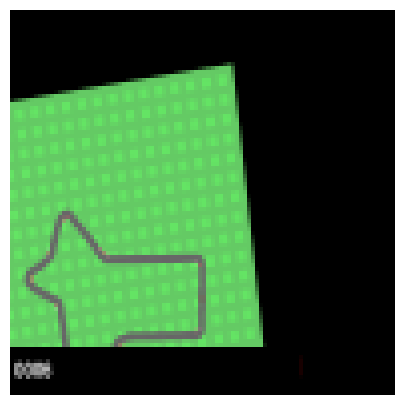

In [7]:
env.reset()
frames = []
# 50 frame은 도입부라서 학습에 사용되지 않음 > PASS
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

In [8]:
# Every frme always contains a black area at the bottom of the frame, so we had better cut this black area.
# Also, Color imformation is not directly related to car racing. So we will use gray image for computation efficiency.
# 학습에 불필요한 부분은 CROP 후에 사용함 (Grayscale로 변환)
def preprocess(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

In [9]:
class ImageEnv(gym.Wrapper):

# skip_frame: 한번 action을 수행하면 4frame동안 진행함
# stack_frame: 4프레임을 모아서 한번의 입력으로 제공함
# initial_no_op: 최초 skip 프레임 수

    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    # 처음으로 돌아감

    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info

    def step(self, action):
        # We take an action for self.skip_frames steps
        # terminated: 완료 / truncated: 실패
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

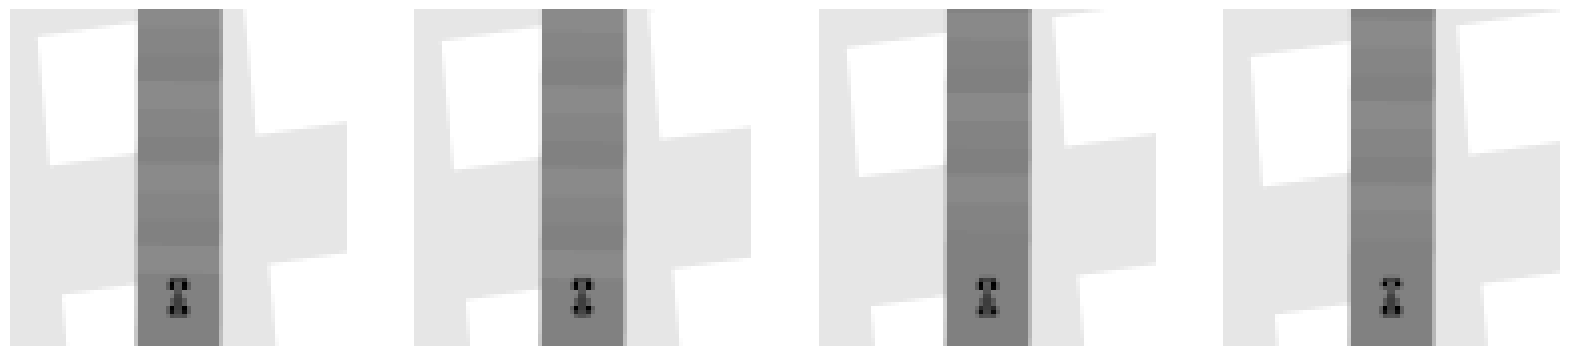

In [10]:
# 하나의 action이 4개의 frame에 적용되는 예시

env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

env.reset()
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # #3 action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [11]:
class Actor(nn.Module):
  def __init__(self,state_dim, action_dim):
    super(Actor,self).__init__()
    self.conv1=nn.Conv2d(state_dim[0],16,kernel_size=8,stride=4) #[N,4,84,84] -> [N,16,20,20]
    self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
    self.in_features=32*9*9
    self.fc1=nn.Linear(self.in_features,256)
    self.fc2=nn.Linear(256,action_dim)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view((-1, self.in_features))
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x),dim=-1)
    return x

class Critic(nn.Module):
  def __init__(self,state_dim):
    super(Critic,self).__init__()
    self.conv1=nn.Conv2d(state_dim[0],16,kernel_size=8,stride=4) #[N,4,84,84] -> [N,16,20,20]
    self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
    self.in_features=32*9*9
    self.fc1=nn.Linear(self.in_features,256)
    self.fc2=nn.Linear(256,1)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view((-1, self.in_features))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [12]:
state_dim = (4, 84, 84)
action_dim = env.action_space.n

actor = Actor(state_dim, action_dim)
critic= Critic(state_dim)
actor_optimizer = optim.Adam(actor.parameters(), lr = 0.0005)
critic_optimizer=optim.Adam(critic.parameters(),lr=0.0005)

In [13]:
def train(env, actor, critic, actor_optimizer, critic_optimizer, gamma):
    actor.train()
    critic.train()
    state, info = env.reset()

    episode_reward = 0
    state_list, action_list, reward_list, next_state_list, done_list = [], [], [], [], []
    terminated = truncated = False

    while not terminated and not truncated:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action_probs = actor(state_tensor)
        action_probs = action_probs.detach().cpu().numpy().squeeze()
        action = np.random.choice(np.arange(action_dim), p=action_probs)

        next_state, reward, terminated, truncated, info = env.step(action)

        state_list.append(state)
        next_state_list.append(next_state)
        action_list.append(action)
        reward_list.append(reward)
        done_list.append(terminated or truncated)

        episode_reward += reward

        if episode_reward < -250:
            terminated = True

        state = next_state

    R = 0.0
    return_array = np.zeros((len(reward_list)))

    state_t = torch.FloatTensor(state_list)
    next_state_t = torch.FloatTensor(next_state_list)
    action_t = torch.LongTensor(action_list).view(-1, 1)
    reward_t = torch.FloatTensor(reward_list).view(-1, 1)
    done_t = torch.FloatTensor(done_list).view(-1, 1)

    action_probs = actor(state_t).gather(1, action_t)
    log_action_probs = torch.log(action_probs)

    critic_t = critic(state_t).view(-1, 1)
    critic_td_t = reward_t + (1 - done_t) * gamma * critic(next_state_t).view(-1, 1)
    advantage_t = critic_td_t - critic_t

    actor_loss = -torch.mean(advantage_t * log_action_probs)
    actor_optimizer.zero_grad()
    actor_loss.backward(retain_graph=True)
    actor_optimizer.step()

    critic_loss = F.smooth_l1_loss(critic_t, critic_td_t)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    return episode_reward

In [18]:
from tqdm import tqdm

In [20]:
MAX_EPISODES = 5000
gamma = 0.99
interval = 10
scores=[]
scores_window=deque(maxlen=interval)
maxscore = -10000

start=time.time()

for episode in tqdm(range(1, MAX_EPISODES+1)):

    episode_reward = train(env, actor,critic, actor_optimizer,critic_optimizer, gamma)

    scores.append(episode_reward)
    scores_window.append(episode_reward)

    avg_score = np.mean(scores_window)
    if avg_score > maxscore:
      max_score = avg_score
      print("Max Score Ever: ", avg_score)
      torch.save(actor.state_dict(), 'checkpoint.pth')
      torch.save(actor.state_dict(), 'actor.pt')
      torch.save(critic.state_dict(), 'critic.pt')

    if episode % interval == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))

    if episode_reward>=400.0:
        print("END!!")
        print("It takes {} seconds".format(time.time()-start))
        torch.save(actor.state_dict(), 'checkpoint.pth')
        break

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
'''
    if episode_reward>=300.0:
        print("300점 넘음")
        torch.save(actor.state_dict(), '/content/drive/MyDrive/RL/checkpoint300.pth')
        torch.save(actor.state_dict(), '/content/drive/MyDrive/RL/actor300.pt')
        torch.save(critic.state_dict(), '/content/drive/MyDrive/RL/critic300.pt')
    if episode_reward>=200.0:
        print("200점 넘음")
        torch.save(actor.state_dict(), '/content/drive/MyDrive/RL/checkpoint200.pth')
        torch.save(actor.state_dict(), '/content/drive/MyDrive/RL/actor200.pt')
        torch.save(critic.state_dict(), '/content/drive/MyDrive/RL/critic200.pt')
    if episode_reward>=100.0:
        print("100점 넘음")
        torch.save(actor.state_dict(), '/content/drive/MyDrive/RL/checkpoint100.pth')
        torch.save(actor.state_dict(), '/content/drive/MyDrive/RL/actor100.pt')
        torch.save(critic.state_dict(), '/content/drive/MyDrive/RL/critic100.pt')
'''

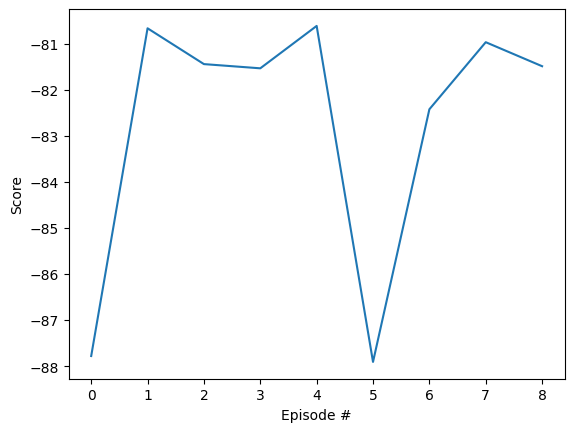

In [30]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
'''
!mkdir video
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(policy, env_name):


    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    policy.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action_probs=policy(torch.FloatTensor(state))
        action_probs=action_probs.detach().cpu().numpy()
        action = np.random.choice(np.arange(), p=action_probs)
        state, reward, done, _ = env.step(action)

    env.close()
'''